# Imports

In [1]:
!pip install ultralytics
!pip install roboflow
!pip install opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import os
import time
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from google.colab import files
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of GPUs: {device_count}")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found. Will use CPU instead.")

# Set device
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

GPU available: True
Number of GPUs: 1
GPU 0: Tesla T4
Using device: 0


# Dataset Download Section

In [4]:
rf = Roboflow(api_key="OOMi0m3PhpE0bSmlr5rx")
project = rf.workspace("luigui-andre-cerna-grados-dpsrr").project("clasificacion-de-mangos")
version = project.version(16)

# Retry mechanism with error handling
retries = 3
for attempt in range(retries):
    try:
        dataset = version.download("yolov12")
        break  # Exit loop if successful
    except ConnectionError as e:
        print(f"Download attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print(f"Retrying in 5 seconds...")
            time.sleep(5)  # Wait before retrying
        else:
            print("Maximum retries reached. Download failed.")
            raise  # Re-raise the exception after max retries

# Rename the dataset folder to a more manageable name
!mv "/content/Clasificación-de-mangos-16" "/content/mango_dataset"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Clasificación-de-mangos-16 in yolov12:: 100%|██████████| 4004/4004 [00:02<00:00, 1386.40it/s]


# Data Preprocessing Section

Starting dataset preprocessing...
Training set: 1529 images
Validation set: 65 images


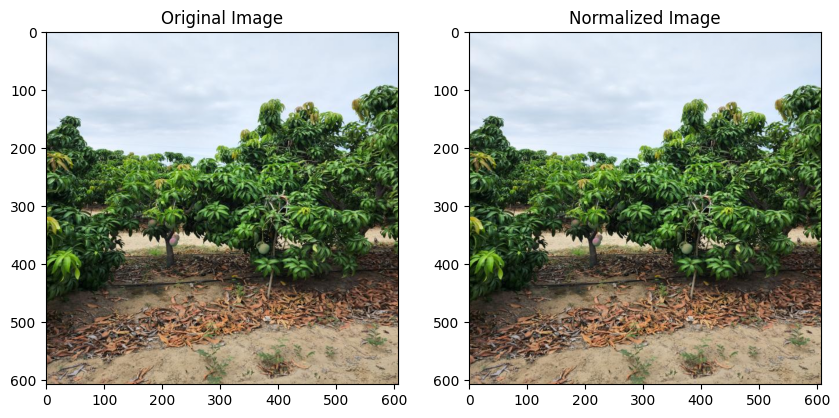

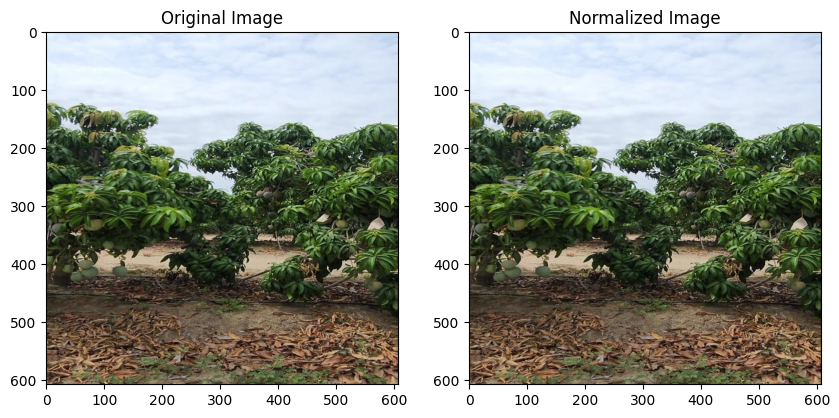

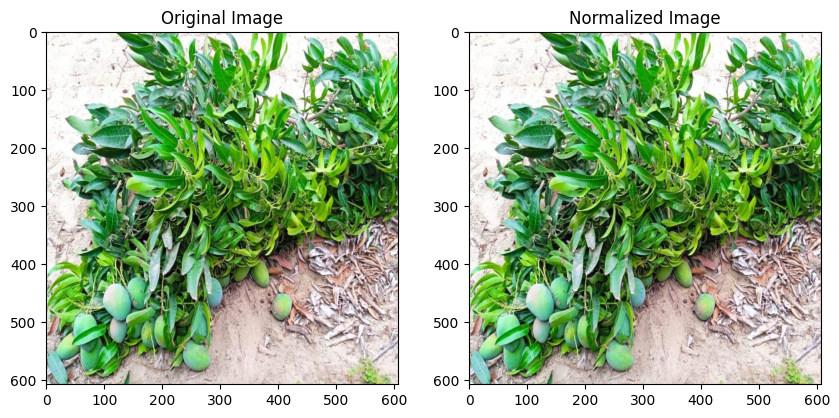

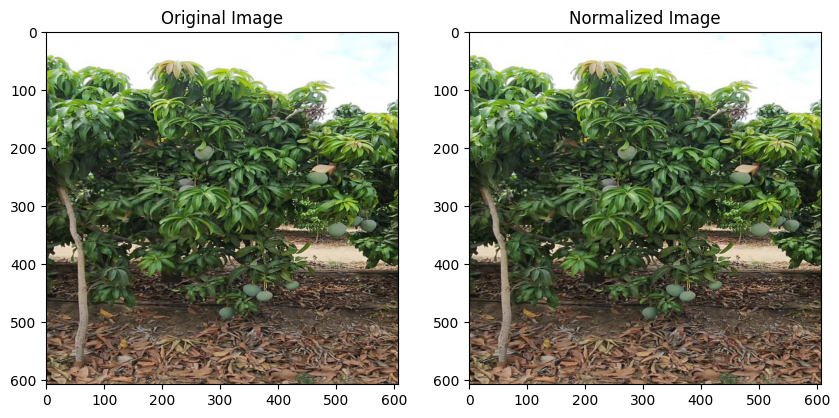

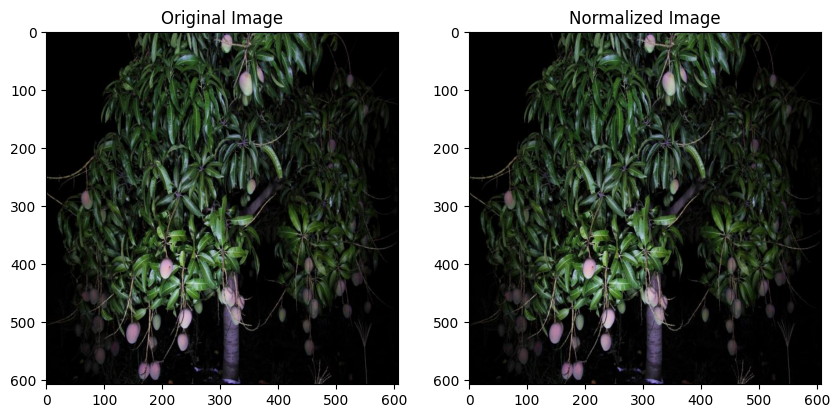

Dataset YAML configuration:
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
Dataset preprocessing completed!


In [5]:
def preprocess_dataset(base_path):
    """
    Preprocess the dataset images to enhance training
    - Apply image normalization
    - Apply image augmentation
    - Check and report dataset statistics
    """
    print("Starting dataset preprocessing...")

    # Set paths
    train_path = os.path.join(base_path, 'train', 'images')
    val_path = os.path.join(base_path, 'valid', 'images')

    # Count datasets and analyze
    train_files = os.listdir(train_path)
    val_files = os.listdir(val_path)

    print(f"Training set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")

    # Sample preprocessing on a few images to test
    sample_images = train_files[:5]  # Process first 5 images as a sample

    for img_file in sample_images:
        img_path = os.path.join(train_path, img_file)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading image {img_file}")
            continue

        # Convert BGR to RGB (OpenCV loads as BGR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize image
        img_norm = img_rgb / 255.0

        # Display original and preprocessed image for verification
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(img_rgb)

        plt.subplot(1, 2, 2)
        plt.title("Normalized Image")
        plt.imshow(img_norm)
        plt.show()

    # Validate dataset YAML file
    with open(os.path.join(base_path, 'data.yaml'), 'r') as f:
        yaml_content = f.read()
        print("Dataset YAML configuration:")
        print(yaml_content)

    # Create a modified YAML file for Ultralytics
    with open(os.path.join(base_path, 'data.yaml'), 'w') as f:
        f.write(f"""
train: {train_path}
val: {val_path}
test: {os.path.join(base_path, 'test', 'images')}

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
        """)

    print("Dataset preprocessing completed!")
    return os.path.join(base_path, 'data.yaml')

# Execute preprocessing
yaml_path = preprocess_dataset('/content/mango_dataset')

# Model Upload

In [6]:
def upload_models():
    """
    Function to upload multiple model .pt files
    """
    print("Please upload your model .pt files. You can select multiple files.")
    uploaded = files.upload()

    if not uploaded:
        print("No models uploaded. Using default model.")
        model_paths = ['/content/yolov12m.pt']
        if not os.path.exists('/content/yolov12m.pt'):
            print("Default model not found. Please upload at least one model.")
            return None
    else:
        model_paths = [file for file in uploaded.keys() if file.endswith('.pt')]

        if not model_paths:
            print("No valid model files (.pt) uploaded.")
            return None

        print(f"Successfully uploaded {len(model_paths)} model files:")
        for i, path in enumerate(model_paths):
            print(f"{i+1}. {path}")

    return model_paths

# Upload models
model_paths = upload_models()

if not model_paths:
    print("No models available for evaluation.")
else:
    print(f"Ready to evaluate {len(model_paths)} models.")

Please upload your model .pt files. You can select multiple files.


Saving mango_detector_v8.pt to mango_detector_v8.pt
Saving mango_detector_v10.pt to mango_detector_v10.pt
Saving mango_detector_v11.pt to mango_detector_v11.pt
Saving mango_detector_v12.pt to mango_detector_v12.pt
Successfully uploaded 4 model files:
1. mango_detector_v8.pt
2. mango_detector_v10.pt
3. mango_detector_v11.pt
4. mango_detector_v12.pt
Ready to evaluate 4 models.


# Metrics

Evaluating metrics for 4 models on device: 0...

===== Evaluating model: mango_detector_v8.pt =====
Successfully loaded model from mango_detector_v8.pt
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 37.9MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1527.1±314.3 MB/s, size: 89.8 KB)



val: Scanning /content/mango_dataset/valid/labels... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<00:00, 2230.96it/s]

val: New cache created: /content/mango_dataset/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


                   all         65        649      0.905      0.853      0.909      0.642
Speed: 5.6ms preprocess, 24.2ms inference, 0.0ms loss, 13.0ms postprocess per image
Results saved to runs/detect/val
Validation completed successfully in 13.39 seconds

----- Metrics for mango_detector_v8.pt -----
mAP@0.5: 0.9087
mAP@0.5:0.95: 0.6425
Precision: 0.9052
Recall: 0.8534
F1-Score: 0.8785

===== Evaluating model: mango_detector_v10.pt =====
Successfully loaded model from mango_detector_v10.pt
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,313,747 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1330.9±305.0 MB/s, size: 71.1 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


                   all         65        649       0.89      0.831      0.897      0.618
Speed: 6.8ms preprocess, 21.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val2
Validation completed successfully in 7.50 seconds

----- Metrics for mango_detector_v10.pt -----
mAP@0.5: 0.8971
mAP@0.5:0.95: 0.6178
Precision: 0.8900
Recall: 0.8305
F1-Score: 0.8592

===== Evaluating model: mango_detector_v11.pt =====
Successfully loaded model from mango_detector_v11.pt
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2423.6±710.8 MB/s, size: 77.1 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


                   all         65        649      0.934      0.834      0.919      0.641
Speed: 6.4ms preprocess, 24.0ms inference, 0.1ms loss, 4.5ms postprocess per image
Results saved to runs/detect/val3
Validation completed successfully in 7.09 seconds

----- Metrics for mango_detector_v11.pt -----
mAP@0.5: 0.9194
mAP@0.5:0.95: 0.6410
Precision: 0.9341
Recall: 0.8336
F1-Score: 0.8810

===== Evaluating model: mango_detector_v12.pt =====
Successfully loaded model from mango_detector_v12.pt
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 19,626,451 parameters, 0 gradients, 59.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2308.1±544.3 MB/s, size: 64.7 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


                   all         65        649      0.917      0.829      0.916      0.641
Speed: 8.1ms preprocess, 28.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val4
Validation completed successfully in 7.49 seconds

----- Metrics for mango_detector_v12.pt -----
mAP@0.5: 0.9162
mAP@0.5:0.95: 0.6412
Precision: 0.9165
Recall: 0.8291
F1-Score: 0.8706

===== Model Comparison =====

Metrics Comparison Table:
                   Model   mAP@0.5  mAP@0.5:0.95  Precision    Recall  \
0   mango_detector_v8.pt  0.908683      0.642457   0.905203  0.853369   
1  mango_detector_v10.pt  0.897133      0.617764   0.889964  0.830508   
2  mango_detector_v11.pt  0.919373      0.640989   0.934051  0.833590   
3  mango_detector_v12.pt  0.916163      0.641153   0.916533  0.829056   

   F1-Score   Time (s)  
0  0.878522  13.386373  
1  0.859209   7.495494  
2  0.880966   7.085825  
3  0.870602   7.493787  


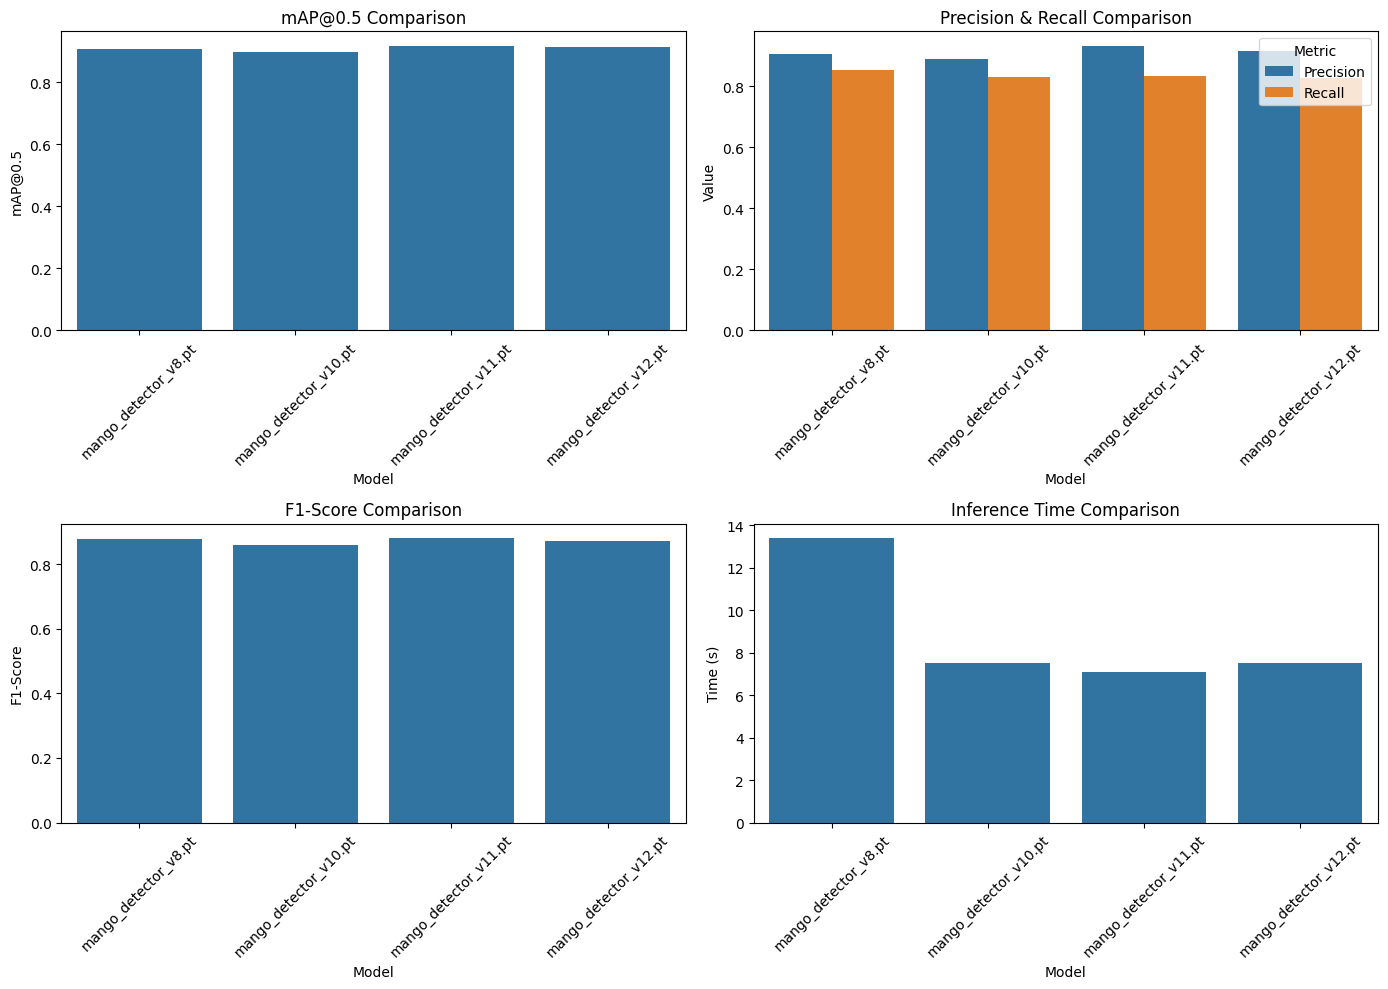

In [7]:
def check_model_metrics(model_paths, yaml_path, device=0):
    """
    Check and visualize metrics for multiple trained models
    """
    print(f"Evaluating metrics for {len(model_paths)} models on device: {device}...")

    results_dict = {}

    for model_path in model_paths:
        model_name = os.path.basename(model_path)
        print(f"\n===== Evaluating model: {model_name} =====")

        # Load the model
        try:
            model = YOLO(model_path)
            print(f"Successfully loaded model from {model_path}")
        except Exception as e:
            print(f"Error loading model {model_name}: {e}")
            continue

        # Time the validation
        try:
            start_time = time.time()
            results = model.val(data=yaml_path, device=device)
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Validation completed successfully in {elapsed_time:.2f} seconds")

            # Store results
            results_dict[model_name] = {
                'results': results,
                'time': elapsed_time
            }

            # Print metrics summary
            metrics = results.box
            print(f"\n----- Metrics for {model_name} -----")
            print(f"mAP@0.5: {metrics.map50:.4f}")
            print(f"mAP@0.5:0.95: {metrics.map:.4f}")
            print(f"Precision: {metrics.p[0]:.4f}")
            print(f"Recall: {metrics.r[0]:.4f}")
            print(f"F1-Score: {metrics.f1[0]:.4f}")

        except Exception as e:
            print(f"Error during validation for {model_name}: {e}")
            continue

    # Compare metrics across models
    if len(results_dict) > 1:
        print("\n===== Model Comparison =====")
        comparison_data = []

        for model_name, data in results_dict.items():
            metrics = data['results'].box
            comparison_data.append({
                'Model': model_name,
                'mAP@0.5': metrics.map50,
                'mAP@0.5:0.95': metrics.map,
                'Precision': metrics.p[0],
                'Recall': metrics.r[0],
                'F1-Score': metrics.f1[0],
                'Time (s)': data['time']
            })

        # Create comparison dataframe
        df_comparison = pd.DataFrame(comparison_data)
        print("\nMetrics Comparison Table:")
        print(df_comparison)

        # Plot comparison
        plt.figure(figsize=(14, 10))

        # mAP Comparison
        plt.subplot(2, 2, 1)
        sns.barplot(x='Model', y='mAP@0.5', data=df_comparison)
        plt.title('mAP@0.5 Comparison')
        plt.xticks(rotation=45)

        # Precision/Recall Comparison
        plt.subplot(2, 2, 2)
        pr_data = pd.melt(df_comparison,
                          id_vars=['Model'],
                          value_vars=['Precision', 'Recall'],
                          var_name='Metric', value_name='Value')
        sns.barplot(x='Model', y='Value', hue='Metric', data=pr_data)
        plt.title('Precision & Recall Comparison')
        plt.xticks(rotation=45)

        # F1-Score Comparison
        plt.subplot(2, 2, 3)
        sns.barplot(x='Model', y='F1-Score', data=df_comparison)
        plt.title('F1-Score Comparison')
        plt.xticks(rotation=45)

        # Time Comparison
        plt.subplot(2, 2, 4)
        sns.barplot(x='Model', y='Time (s)', data=df_comparison)
        plt.title('Inference Time Comparison')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    return results_dict

# Call the function with model and dataset paths
if model_paths:
    model_metrics = check_model_metrics(model_paths, yaml_path, device=device)

# Model Inference

Upload an image for inference:


Saving mango-pic.jpg to mango-pic.jpg

Running inference with model: mango_detector_v8.pt

image 1/1 /content/mango-pic.jpg: 448x640 10 Mangos, 49.2ms
Speed: 2.7ms preprocess, 49.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Inference completed in 0.4669 seconds
Model mango_detector_v8.pt detected 10 mangoes

Running inference with model: mango_detector_v10.pt

image 1/1 /content/mango-pic.jpg: 448x640 11 Mangos, 24.6ms
Speed: 2.6ms preprocess, 24.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
Inference completed in 0.3566 seconds
Model mango_detector_v10.pt detected 11 mangoes

Running inference with model: mango_detector_v11.pt

image 1/1 /content/mango-pic.jpg: 448x640 16 Mangos, 42.1ms
Speed: 2.6ms preprocess, 42.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Inference completed in 0.3939 seconds
Model mango_detector_v11.pt detected 16 mangoes

Running inference with model: mango_detector_v12.pt

image 1/1 /content/

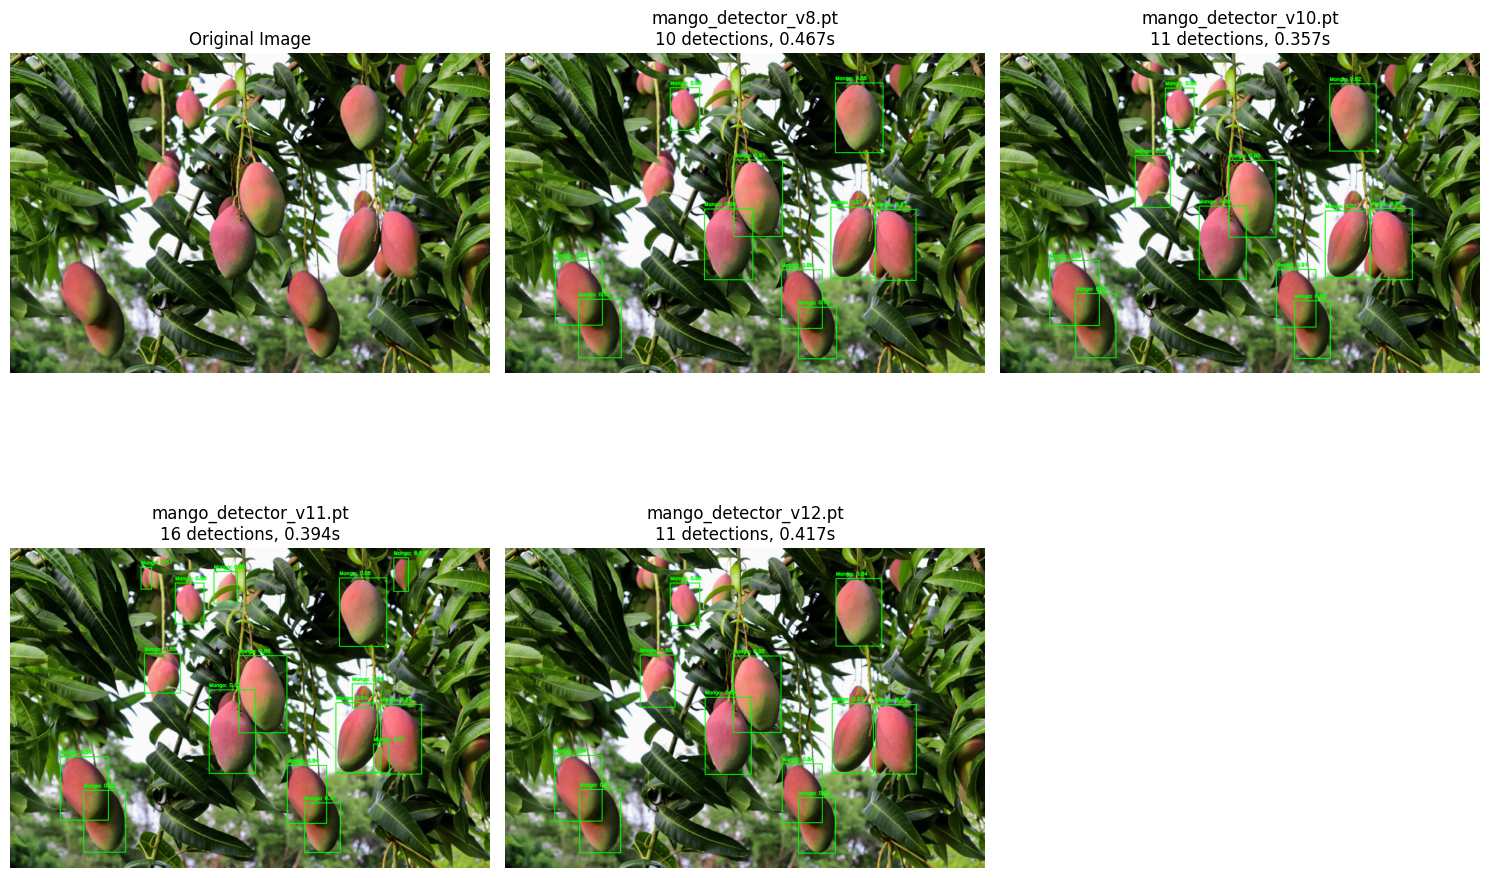


Inference Comparison Table:
                   Model  Detections  Inference Time (s)
0   mango_detector_v8.pt          10            0.466908
1  mango_detector_v10.pt          11            0.356565
2  mango_detector_v11.pt          16            0.393912
3  mango_detector_v12.pt          11            0.416631


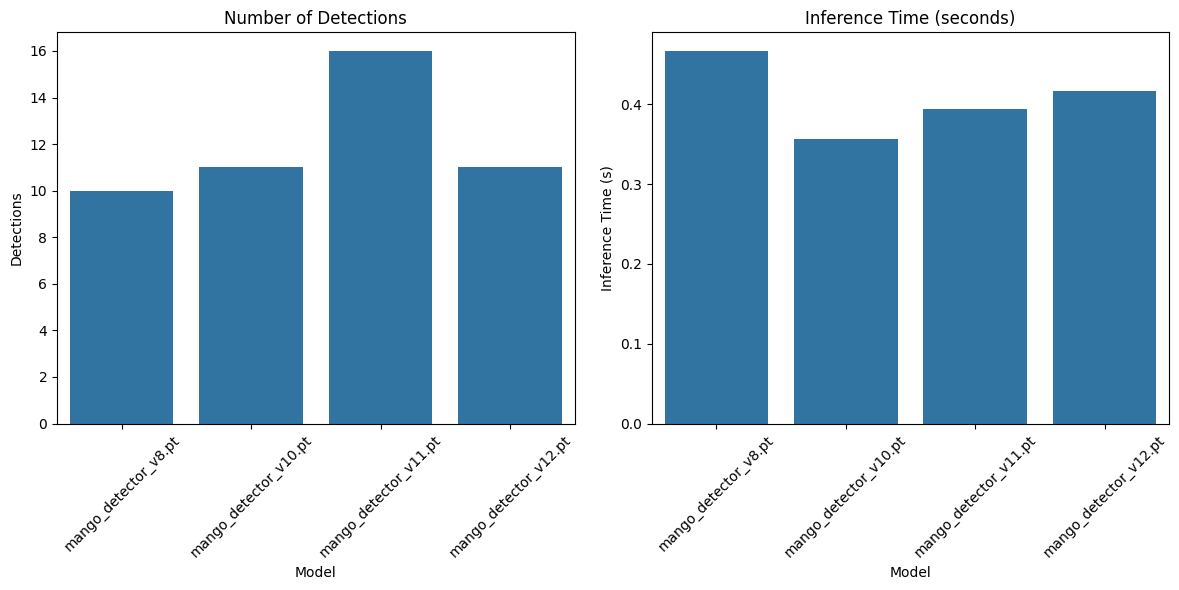

In [8]:
def inference_on_image(model_paths, device=0):
    """
    Perform inference on uploaded images using multiple models
    """
    print("Upload an image for inference:")
    uploaded = files.upload()  # Prompt to upload an image

    if not uploaded:
        print("No image uploaded!")
        return

    uploaded_file = list(uploaded.keys())[0]
    image_path = uploaded_file

    # Create a directory to save results for each model
    results_dir = '/content/comparison_results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # Load image for display
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Create visualization grid
    num_models = len(model_paths)
    grid_size = int(np.ceil(np.sqrt(num_models + 1)))  # +1 for original image

    plt.figure(figsize=(15, 15))

    # Show original image
    plt.subplot(grid_size, grid_size, 1)
    plt.title("Original Image")
    plt.imshow(original_img_rgb)
    plt.axis('off')

    # Process each model
    inference_results = {}

    for i, model_path in enumerate(model_paths):
        model_name = os.path.basename(model_path)
        print(f"\nRunning inference with model: {model_name}")

        try:
            # Load model
            model = YOLO(model_path)

            # Run inference
            start_time = time.time()
            results = model.predict(
                source=image_path,
                conf=0.5,
                save=False,  # Don't save the images automatically
                device=device
            )
            end_time = time.time()
            inference_time = end_time - start_time

            print(f"Inference completed in {inference_time:.4f} seconds")

            # Process results
            result = results[0]
            boxes = result.boxes

            # Store results
            inference_results[model_name] = {
                'num_detections': len(boxes),
                'time': inference_time,
                'boxes': boxes,
                'result': result
            }

            print(f"Model {model_name} detected {len(boxes)} mangoes")

            # Create a copy of the original image for visualization
            img_with_boxes = original_img.copy()

            # Draw bounding boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                conf = box.conf[0].item()
                cls = int(box.cls[0].item())
                cls_name = model.names[cls]

                # Draw rectangle
                cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Add label
                label = f"{cls_name}: {conf:.2f}"
                cv2.putText(img_with_boxes, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Convert to RGB for display
            img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

            # Display in grid
            plt.subplot(grid_size, grid_size, i + 2)  # +2 because original image is at position 1
            plt.title(f"{model_name}\n{len(boxes)} detections, {inference_time:.3f}s")
            plt.imshow(img_with_boxes_rgb)
            plt.axis('off')

            # Save the result
            result_path = os.path.join(results_dir, f"{model_name}_result.jpg")
            cv2.imwrite(result_path, img_with_boxes)

        except Exception as e:
            print(f"Error during inference with model {model_name}: {e}")

    plt.tight_layout()
    plt.show()

    # Display comparison table
    if len(inference_results) > 1:
        comparison_data = []

        for model_name, data in inference_results.items():
            comparison_data.append({
                'Model': model_name,
                'Detections': data['num_detections'],
                'Inference Time (s)': data['time']
            })

        df_comparison = pd.DataFrame(comparison_data)
        print("\nInference Comparison Table:")
        print(df_comparison)

        # Plot comparison
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x='Model', y='Detections', data=df_comparison)
        plt.title('Number of Detections')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.barplot(x='Model', y='Inference Time (s)', data=df_comparison)
        plt.title('Inference Time (seconds)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    return inference_results

# Run inference with the uploaded models
if model_paths:
    try:
        inference_results = inference_on_image(model_paths, device=device)
    except Exception as e:
        print(f"Error during inference: {e}")
else:
    print("No model paths defined. Skipping inference.")